# Solution for Homework 3

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Problem 3: Spectrum of raised cosine pulse

Plot the PSD of a linearly modulated signal when raised cosine pulses are used for pulse shaping. Use the same roll-off factors as in the plot above. Remember that the PSD is proportional to $|H_{RC}(f)|^2$. Use a normalized frequency axis that spans from $-2 \leq fT \leq 2$.



**Answer:** The notebook gives an expression for the Fourier transform of the raised cosine pulse:
$$
H_{RC}(f) = \begin{cases}
    T & |fT| \leq \frac{1-a}{2} \\
    \frac{T}{2}(1 - \sin(\frac{\pi T}{a}(|f|-\frac{1}{2T}))) & \frac{1-a}{2} \leq |fT| \leq \frac{1+a}{2} \\
    0 & |fT| >  \frac{1+a}{2}
\end{cases}
$$
Here is a function for computing $_{RC}(f)$.

In [11]:
def H_RC(f, alpha, T=1.0):
    """Compute the Fourier Transform of a Raised Cosine Pulse
    
    Inputs:
    f - vector of frequencies to compute H_RC for
    alpha - roll-off factor
    T - symbol period (default: 1.0)

    Returns:
    Vector containing frequency response
    """
    fT = f*T
    H = np.zeros_like(fT)

    for n in range(len(fT)):
        if np.abs(fT[n]) <= (1-alpha)/2:
            H[n] = T
        elif np.abs(fT[n]) <= (1+alpha)/2:
            H[n] = T/2 * (1 - np.sin(np.pi/alpha * (np.abs(fT[n]) - 0.5) ) )
        else:
            H[n] = 0

    return H            

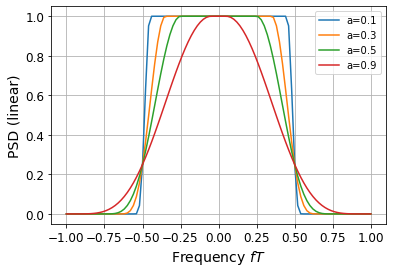

In [12]:
ff = np.linspace(-1, 1, 101)

for a in [0.1, 0.3, 0.5, 0.9]:
    plt.plot(ff, H_RC(ff, a, 1)**2, label='a={:3.1f}'.format(a))
plt.grid()
plt.xlabel('Frequency $fT$')
plt.ylabel('PSD (linear)')
plt.legend()

plt.show()